In [1]:
import sys
sys.path.append('../../../modules')
import torch
from nn_rbf import RBF_Free_All as RBF
from notable_kernels import *

It sometimes is useful to define a differential operator, for instance, as initially defined [here](https://stackoverflow.com/questions/75988990/efficient-calculation-of-derivatives-for-pinn-solvers-in-pytorch):

In [2]:
def diff(y: torch.Tensor, xs: list[torch.Tensor]):
    grad = y
    ones = torch.ones_like(y)
    for x in xs:
        grad = torch.autograd.grad(grad, x, grad_outputs=ones, create_graph=True)[0]
    return grad

The ODE is $ u_{x x} = 2 $, which we can immediately write down as some mean-squared error:

In [3]:
def ode(model: RBF, x: torch.Tensor) -> torch.Tensor:
    return torch.mean((diff(model(x), [x, x]) - 2) ** 2)

We have two boundary conditions in $0$ and $1$. They prescribe the function to have the value $1/4$. We write it as well as a mean squared error.

In [4]:
def bc(model: RBF) -> torch.Tensor:
    u_0 = model(torch.tensor([[0.]], requires_grad=True))
    u_1 = model(torch.tensor([[1.]], requires_grad=True))
    loss = (((u_0 - 0.25) ** 2) + ((u_1 - 0.25) ** 2))/2
    return loss

Notice that the ''weight'' of the two points featured in `bc` is bound to be more significant to the weight of any point featured in `ode`.

The loss of our PINN is the sum of the `ode` and `bc`:

In [5]:
def total_loss(model, x):
    return ode(model, x) + bc(model)

We now sample a significant amount of points, instance our model and equip it with the Adam optimizer. 

Setting the flag `requires_grad` to `True` on our training points guarantees that we can apply the differential of our model with respect to them.

In [23]:
x_train = torch.linspace(0.01, 0.99, 15, requires_grad=True).reshape(-1, 1)

model = RBF(1, 5, 1, gaussian_kernel)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10000

loss_log = torch.zeros(num_epochs)
linf_log = torch.zeros_like(loss_log)

x_ver = torch.linspace(0, 1, 4000).reshape(-1, 1)

In [24]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = total_loss(model, x_train)
    
    loss_log[epoch] = loss.item()
    linf_log[epoch] = (model(x_ver) - (x_ver - 1/2) ** 2).abs().max()

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4e}')

Epoch [1000/10000], Loss: 5.1603e-03
Epoch [2000/10000], Loss: 1.9609e-03
Epoch [3000/10000], Loss: 1.0957e-03
Epoch [4000/10000], Loss: 6.8776e-04
Epoch [5000/10000], Loss: 4.5680e-04
Epoch [6000/10000], Loss: 3.2261e-04
Epoch [7000/10000], Loss: 2.5572e-04
Epoch [8000/10000], Loss: 2.3167e-04
Epoch [9000/10000], Loss: 1.2039e-04
Epoch [10000/10000], Loss: 9.5476e-05


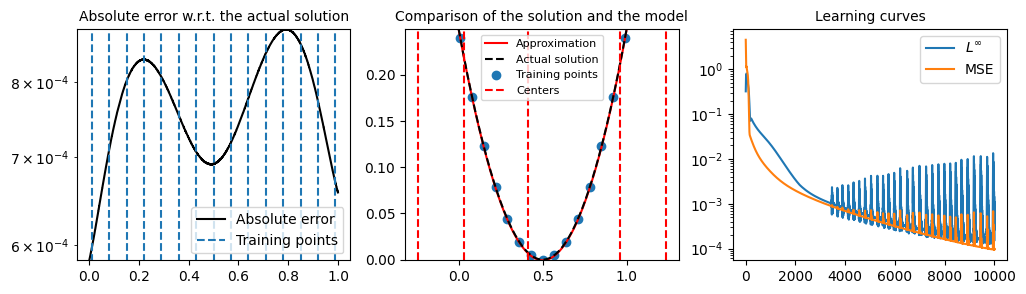

In [38]:
import matplotlib.pyplot as plt

x_ver = torch.linspace(0, 1, 4000).reshape(-1, 1)
sol = model(x_ver)
err = torch.abs(sol - (x_ver - 1/2) ** 2)

with torch.no_grad():
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.semilogy(x_ver, err, label="Absolute error", color="black")
    plt.vlines(x_train, ymin=0, ymax=1, label="Training points", linestyles='--')
    plt.ylim(torch.min(err), torch.max(err))
    plt.legend()
    plt.title('Absolute error w.r.t. the actual solution', fontsize=10)

    plt.subplot(1,3,2)
    plt.plot(x_ver, sol, label="Approximation", color="red")
    plt.plot(x_ver, (x_ver-1/2)**2, label="Actual solution", color="black", linestyle='--')
    plt.scatter(x_train, (x_train - 1/2) ** 2, label="Training points")
    plt.vlines(model.centers, ymin=0, ymax=1, color="red", linestyles='--', label="Centers")
    plt.ylim(torch.min(sol), torch.max(sol))
    plt.legend(loc='upper center', fontsize=8)
    plt.title('Comparison of the solution and the model', fontsize=10)

    plt.subplot(1,3,3)
    plt.semilogy(linf_log, label=r"$L^{\infty}$")
    plt.semilogy(loss_log, label="MSE")
    plt.legend()
    plt.title('Learning curves', fontsize=10)

Precisely because we have access to the exact solution, we can explicitly verify the error term of our model's output against it.

- The absolute error shows that we can give three digits of precision in our solution. 
- We have also visually compared both solutions as well as the location of the RBF centers. Much like in the previous discussions, some of them leave the domain of the problem.
- The learning curves show that the $L^\infty$-norm as well as the MSE decrease, the former eventually finding a plateau at the end of the training process. The action of the Adam optimizer causes some spikes to happen every few iterations, which ensures that we do not get stuck in local minima.

For the sake of exhaustiveness, we now show the RBF parameters that the training process found:

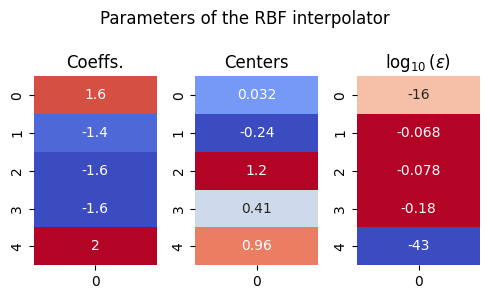

In [88]:
import seaborn as sns

with torch.no_grad():
    weight_list = model.output_layer.weight.reshape(-1,1).tolist()
    centers_list = model.get_centers().reshape(-1,1).tolist()
    shape_list = torch.log10(model.shape).reshape(-1,1).tolist()

    plt.figure(figsize=(5, 3))

    plt.subplot(1, 3, 1)
    sns.heatmap(weight_list, annot=True, cmap="coolwarm", cbar=False)
    plt.title("Coeffs.")

    plt.subplot(1, 3, 2)
    sns.heatmap(centers_list, annot=True, cmap="coolwarm", cbar=False)
    plt.title("Centers")

    plt.subplot(1, 3, 3)
    sns.heatmap(shape_list, annot=True, cmap="coolwarm", cbar=False)
    plt.title(r"$\log_{10} (\varepsilon)$")

    plt.suptitle('Parameters of the RBF interpolator')

    plt.tight_layout()
    plt.show()

This last picture shows that the action of two of the addends in the interpolator is simply adding $1.6$ and $2$, respectively. Other than that, the model looks for shape parameters $\varepsilon<1$, which are known to provide higher accuracy.